In [21]:
# 1) Imports & Hyperparameters --------------------------------------------------
import random
import numpy as np
import pandas as pd
from collections import Counter

import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

from transformers import BertTokenizer

In [22]:
# Hyperparameters
SEED           = 42
DATA_PATH      = "Cleaned_Tickets.csv"
MODEL_NAME     = "bert-base-cased"
MAX_LEN        = 256
BATCH_SIZE     = 32
VAL_BATCH_SIZE = 64
EMBED_DIM      = 128
HIDDEN_DIM     = 256
LR             = 1e-3
NUM_EPOCHS     = 50
PATIENCE       = 2
THRESH_RANGE   = np.linspace(0.1, 0.9, 17)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [24]:
# 2) Load & Preprocess Data -----------------------------------------------------
df = pd.read_csv(DATA_PATH)
# Combine subject + body
df['text'] = df['subject'].str.strip() + " " + df['body'].str.strip()
# Build tag lists
df['tags_list'] = df[['tag_1','tag_2','tag_3']].values.tolist()

all_tag_lists = df['tags_list'].tolist()
full_tags     = sorted({t for tags in all_tag_lists for t in tags})
print(f"Found {len(full_tags)} unique tags.")

Found 367 unique tags.


In [25]:
# 3) Cluster Tags by Semantic Embedding ----------------------------------------
# 3a) Embed tags
sbert = SentenceTransformer("all-mpnet-base-v2")
tag_embeddings = sbert.encode(full_tags, batch_size=64, show_progress_bar=True)

# 3b) Agglomerative clustering
clustering = AgglomerativeClustering(
    n_clusters=140,
    linkage="ward",
)
cluster_ids = clustering.fit_predict(tag_embeddings)
n_clusters  = cluster_ids.max() + 1
print(f"→ Produced {n_clusters} clusters.")

# 3c) Map tags to cluster names
cluster_map = {tag: f"cluster_{cid}" for tag, cid in zip(full_tags, cluster_ids)}

# 3d) Apply mapping back to tickets
df['cluster_tags'] = df['tags_list'].apply(lambda tags: list({cluster_map[t] for t in tags}))

Batches: 100%|██████████| 6/6 [00:00<00:00, 55.39it/s]

→ Produced 140 clusters.


In [26]:
# 4) Binarize Cluster Labels ----------------------------------------------------
cluster_classes = sorted({f"cluster_{i}" for i in range(n_clusters)})
mlb_cluster = MultiLabelBinarizer(classes=cluster_classes)
mlb_cluster.fit(df['cluster_tags'])
y_clusters = mlb_cluster.transform(df['cluster_tags'])
print("Cluster label matrix shape:", y_clusters.shape)  # (N, n_clusters)

Cluster label matrix shape: (16337, 140)


In [27]:
# 5) Train/Val/Test Split -------------------------------------------------------
texts  = df['text'].tolist()
labels = y_clusters

X_temp, X_test, y_temp, y_test = train_test_split(
    texts, labels, test_size=0.10, random_state=SEED, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.10, random_state=SEED, shuffle=True
)
raw_y_train = [list(np.where(row==1)[0]) for row in y_train]  # for sampler

In [28]:
# 6) Tokenizer & Datasets --------------------------------------------------------
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

class TagDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=MAX_LEN):
        self.texts     = texts
        self.labels    = labels
        self.tokenizer = tokenizer
        self.max_length= max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            padding="max_length", truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids":      enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels":         torch.tensor(self.labels[idx], dtype=torch.float)
        }

In [29]:
# 6a) Prepare samplers
flat_tags      = [cid for tags in raw_y_train for cid in tags]
tag_freq       = Counter(flat_tags)
inv_freq       = {cid: 1.0/count for cid,count in tag_freq.items()}
sample_weights = [sum(inv_freq[cid] for cid in tags) for tags in raw_y_train]
sampler        = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# 6b) Instantiate DataLoaders
train_ds = TagDataset(X_train, y_train, tokenizer)
val_ds   = TagDataset(X_val,   y_val,   tokenizer)
test_ds  = TagDataset(X_test,  y_test,  tokenizer)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=0)

In [30]:
# 7) Model Definition -----------------------------------------------------------
class TagClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_tags):
        super().__init__()
        self.embed      = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc1        = nn.Linear(embed_dim, hidden_dim)
        self.relu       = nn.ReLU()
        self.classifier = nn.Linear(hidden_dim, num_tags)

    def forward(self, input_ids, attention_mask):
        x      = self.embed(input_ids)
        x      = x * attention_mask.unsqueeze(-1)
        summed = x.sum(dim=1)
        counts = attention_mask.sum(dim=1, keepdim=True).clamp(min=1)
        avg    = summed / counts
        h      = self.relu(self.fc1(avg))
        return self.classifier(h)

model = TagClassifier(
    vocab_size=tokenizer.vocab_size,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_tags=n_clusters
).to(device)

In [31]:
# 8) Training & Evaluation Helpers ----------------------------------------------
optimizer = AdamW(model.parameters(), lr=LR)
loss_fn   = nn.BCEWithLogitsLoss()

class EarlyStopping:
    def __init__(self, patience=PATIENCE, mode="max", delta=0.0):
        self.patience, self.mode, self.delta = patience, mode, delta
        self.best, self.bad_epochs, self.should_stop = None, 0, False

    def step(self, metric):
        if self.best is None:
            self.best = metric; return
        improved = (metric > self.best + self.delta) if self.mode=="max" \
                   else (metric < self.best - self.delta)
        if improved:
            self.best, self.bad_epochs = metric, 0
        else:
            self.bad_epochs += 1
            if self.bad_epochs >= self.patience:
                self.should_stop = True

def train_epoch():
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        ids, mask, labs = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
        optimizer.zero_grad()
        logits = model(ids, mask)
        loss   = loss_fn(logits, labs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def eval_loader(loader, thresholds=0.5):
    model.eval()
    all_logits, all_true, total_loss = [], [], 0.0
    with torch.no_grad():
        for batch in loader:
            ids, mask, labs = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
            logits = model(ids, mask)
            total_loss += loss_fn(logits, labs).item()
            all_logits.append(logits.cpu().numpy())
            all_true.append(labs.cpu().numpy())
    avg_loss = total_loss / len(loader)
    logits  = np.vstack(all_logits)
    y_true  = np.vstack(all_true)
    probs   = 1/(1+np.exp(-logits))
    if isinstance(thresholds, (float,int)):
        y_pred = (probs > thresholds).astype(int)
    else:
        y_pred = np.stack([(probs[:,i]>thresholds[i]) for i in range(probs.shape[1])], axis=1).astype(int)
    precision = precision_score(y_true, y_pred, average="micro", zero_division=0)
    recall    = recall_score(y_true, y_pred, average="micro", zero_division=0)
    f1        = f1_score(y_true, y_pred, average="micro", zero_division=0)
    return {"loss":avg_loss, "precision":precision, "recall":recall, "f1":f1, "y_true":y_true, "y_pred":y_pred}

def tune_thresholds(val_logits, val_true):
    best_thresh = []
    for i in range(val_true.shape[1]):
        best_f1, best_t = 0, 0.5
        for t in THRESH_RANGE:
            preds_i = (1/(1+np.exp(-val_logits[:,i]))>t).astype(int)
            f1_ = f1_score(val_true[:,i], preds_i, zero_division=0)
            if f1_ > best_f1:
                best_f1, best_t = f1_, t
        best_thresh.append(best_t)
    return np.array(best_thresh)

In [32]:
# 9) Training Loop & Checkpointing ----------------------------------------------
checkpoint = "best_cluster_model.pt"
best_f1     = -float("inf")
early_stop  = EarlyStopping()

for epoch in range(1, NUM_EPOCHS+1):
    tr_loss = train_epoch()
    val_res = eval_loader(val_loader)
    if val_res["f1"] > best_f1:
        best_f1 = val_res["f1"]
        torch.save(model.state_dict(), checkpoint)
        print(f"Epoch {epoch}: new best Val F1={best_f1:.4f}")
    print(f"Ep{epoch} | TrL {tr_loss:.4f} | ValL {val_res['loss']:.4f} | F1 {val_res['f1']:.4f}")
    early_stop.step(val_res["f1"])
    if early_stop.should_stop:
        print("Early stopping."); break

Epoch 1: new best Val F1=0.2348
Ep1 | TrL 0.1109 | ValL 0.0604 | F1 0.2348
Epoch 2: new best Val F1=0.3788
Ep2 | TrL 0.0541 | ValL 0.0532 | F1 0.3788
Epoch 3: new best Val F1=0.4337
Ep3 | TrL 0.0389 | ValL 0.0506 | F1 0.4337
Epoch 4: new best Val F1=0.5073
Ep4 | TrL 0.0302 | ValL 0.0477 | F1 0.5073
Epoch 5: new best Val F1=0.5153
Ep5 | TrL 0.0241 | ValL 0.0482 | F1 0.5153
Epoch 6: new best Val F1=0.5571
Ep6 | TrL 0.0203 | ValL 0.0453 | F1 0.5571
Epoch 7: new best Val F1=0.5737
Ep7 | TrL 0.0173 | ValL 0.0454 | F1 0.5737
Epoch 8: new best Val F1=0.5854
Ep8 | TrL 0.0153 | ValL 0.0446 | F1 0.5854
Epoch 9: new best Val F1=0.5962
Ep9 | TrL 0.0140 | ValL 0.0437 | F1 0.5962
Epoch 10: new best Val F1=0.6050
Ep10 | TrL 0.0122 | ValL 0.0437 | F1 0.6050
Epoch 11: new best Val F1=0.6123
Ep11 | TrL 0.0113 | ValL 0.0429 | F1 0.6123
Epoch 12: new best Val F1=0.6306
Ep12 | TrL 0.0105 | ValL 0.0421 | F1 0.6306
Epoch 13: new best Val F1=0.6377
Ep13 | TrL 0.0097 | ValL 0.0421 | F1 0.6377
Ep14 | TrL 0.0090

In [33]:
# 10) Threshold Tuning on Validation --------------------------------------------
model.load_state_dict(torch.load(checkpoint, map_location=device))
model.eval()
val_logits, val_true = [], []
with torch.no_grad():
    for batch in val_loader:
        out = model(batch["input_ids"].to(device), batch["attention_mask"].to(device)).cpu().numpy()
        val_logits.append(out)
        val_true.append(batch["labels"].cpu().numpy())
val_logits = np.vstack(val_logits)
val_true   = np.vstack(val_true)
best_thresh = tune_thresholds(val_logits, val_true)
print("Per-cluster thresholds:", best_thresh)

C:\Users\chria\AppData\Local\Temp\ipykernel_336\3336723198.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint, map_location=devi

Per-cluster thresholds: [0.75 0.5  0.7  0.5  0.5  0.5  0.5  0.45 0.45 0.5  0.3  0.5  0.5  0.5
 0.1  0.5  0.5  0.5  0.5  0.3  0.25 0.5  0.75 0.5  0.8  0.35 0.5  0.35
 0.55 0.1  0.5  0.5  0.1  0.5  0.5  0.7  0.5  0.25 0.5  0.5  0.5  0.5
 0.5  0.25 0.35 0.5  0.75 0.15 0.3  0.2  0.7  0.5  0.5  0.5  0.15 0.5
 0.15 0.25 0.4  0.5  0.5  0.25 0.55 0.5  0.45 0.9  0.5  0.5  0.35 0.25
 0.5  0.5  0.5  0.5  0.2  0.5  0.5  0.4  0.3  0.45 0.35 0.5  0.75 0.7
 0.75 0.8  0.5  0.25 0.5  0.7  0.5  0.3  0.5  0.15 0.4  0.5  0.35 0.5
 0.8  0.5  0.15 0.5  0.5  0.15 0.5  0.5  0.4  0.5  0.3  0.45 0.5  0.4
 0.3  0.5  0.5  0.6  0.1  0.45 0.5  0.5  0.9  0.4  0.5  0.5  0.5  0.5
 0.5  0.1  0.35 0.5  0.5  0.5  0.5  0.7  0.5  0.5  0.5  0.5  0.9  0.3 ]


In [34]:
# 11) Final Test Evaluation ------------------------------------------------------
test_res = eval_loader(test_loader, thresholds=best_thresh)
print("\n--- Test Results ---")
print(f"Micro P:{test_res['precision']:.4f} R:{test_res['recall']:.4f} F1:{test_res['f1']:.4f}")
macro_f1 = f1_score(test_res['y_true'], test_res['y_pred'], average="macro", zero_division=0)
print(f"Macro F1: {macro_f1:.4f}")
print(classification_report(test_res['y_true'], test_res['y_pred'],
                            target_names=mlb_cluster.classes_, zero_division=0))


--- Test Results ---
Micro P:0.6344 R:0.7048 F1:0.6678
Macro F1: 0.2201
              precision    recall  f1-score   support

   cluster_0       0.62      0.17      0.27        29
   cluster_1       0.00      0.00      0.00         1
  cluster_10       0.45      0.38      0.42        13
 cluster_100       0.00      0.00      0.00         0
 cluster_101       0.00      0.00      0.00         0
 cluster_102       0.00      0.00      0.00         0
 cluster_103       0.00      0.00      0.00         0
 cluster_104       0.96      0.93      0.95       334
 cluster_105       0.00      0.00      0.00         1
 cluster_106       0.00      0.00      0.00         0
 cluster_107       0.00      0.00      0.00         1
 cluster_108       0.00      0.00      0.00         1
 cluster_109       0.00      0.00      0.00         0
  cluster_11       0.00      0.00      0.00         0
 cluster_110       0.00      0.00      0.00         1
 cluster_111       0.00      0.00      0.00         0
 cluster

Current clusters (n=140):
  • Silhouette Score        = 0.1366   (higher is better, max=1)
  • Calinski–Harabasz Score = 3.8    (higher is better)
  • Davies–Bouldin Score    = 1.2649   (lower is better)


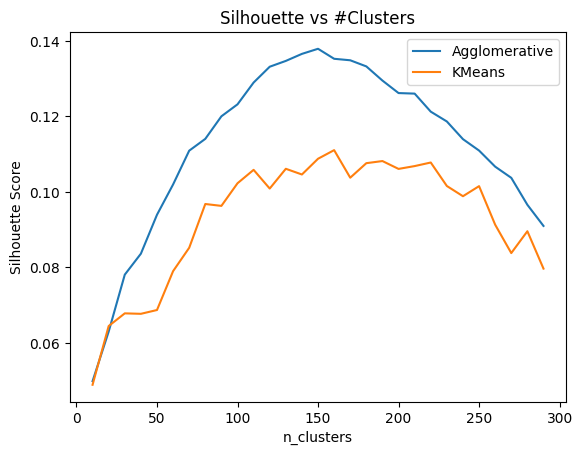

In [35]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

# 1) Evaluate your current clustering
sil = silhouette_score(tag_embeddings, cluster_ids, metric="euclidean")
ch  = calinski_harabasz_score(tag_embeddings, cluster_ids)
db  = davies_bouldin_score(tag_embeddings, cluster_ids)

print(f"Current clusters (n={cluster_ids.max()+1}):")
print(f"  • Silhouette Score        = {sil:.4f}   (higher is better, max=1)")
print(f"  • Calinski–Harabasz Score = {ch:.1f}    (higher is better)")
print(f"  • Davies–Bouldin Score    = {db:.4f}   (lower is better)")

# 2) Sweep n_clusters for Agglomerative + KMeans to find a better granularity
cluster_range = list(range(10, min(300, len(full_tags)), 10))
sil_scores_agg = []
sil_scores_km  = []

for k in cluster_range:
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    lbls_agg = agg.fit_predict(tag_embeddings)
    sil_scores_agg.append(
        silhouette_score(tag_embeddings, lbls_agg, metric="euclidean")
    )
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    lbls_km = km.fit_predict(tag_embeddings)
    sil_scores_km.append(
        silhouette_score(tag_embeddings, lbls_km, metric="euclidean")
    )

# 3) Plot the silhouette curve
plt.plot(cluster_range, sil_scores_agg, label="Agglomerative")
plt.plot(cluster_range, sil_scores_km,  label="KMeans")
plt.xlabel("n_clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette vs #Clusters")
plt.legend()
plt.show()